In [2]:
## I/ PRÉPARATION DES DONNÉES
# objectif : charger, nettoyer et recaler les données garmin sur le temps officiel

import fitparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# lecture du fichier
print("chargement du fichier fit...")
fitfile = fitparse.FitFile('trail_velan.fit')

data_points = []
for record in fitfile.get_messages('record'):
    record_data = {}
    for record_data_entry in record:
        record_data[record_data_entry.name] = record_data_entry.value
    data_points.append(record_data)

df = pd.DataFrame(data_points)

# sécurité : vérification que le fichier n'est pas vide
if df.empty:
    raise ValueError("erreur : aucune donnée trouvée dans le fichier fit !")

print(f"points gps trouvés : {len(df)}")

# standardisation des noms de colonnes garmin
# on renomme pour avoir des variables claires
df.rename(columns={
    'enhanced_speed': 'speed',
    'enhanced_altitude': 'altitude',
    'pos_lat': 'position_lat',
    'pos_long': 'position_long'
}, inplace=True, errors='ignore')

# conversion gps (semicircles -> degrés)
if 'position_lat' in df.columns:
    facteur = 180 / (2**31)
    df['latitude'] = df['position_lat'] * facteur
    df['longitude'] = df['position_long'] * facteur
    df.drop(['position_lat', 'position_long'], axis=1, inplace=True)

# indexation temporelle
# on met le timestamp en index (si pas déjà fait)
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp').sort_index()
else:
    print("info : timestamp déjà en index")

# nettoyage des valeurs manquantes
# on ne traite que les colonnes utiles présentes
cols_utiles = ['heart_rate', 'speed', 'altitude', 'cadence', 'distance', 'power']
cols_clean = [c for c in cols_utiles if c in df.columns]

for col in cols_clean:
    df[col] = df[col].interpolate(method='linear').ffill().bfill()

# recalage chronométrique (correction du départ manqué)
# données officielles : à définir
temps_officiel_sec = (3 * 3600) + (51 * 60) 
dist_officielle = 21000 

# calcul du décalage
dist_montre = df['distance'].max() if 'distance' in df.columns else 0
temps_montre = (df.index.max() - df.index.min()).total_seconds()

diff_dist = dist_officielle - dist_montre
diff_temps = temps_officiel_sec - temps_montre

print(f"correction départ : +{diff_dist:.0f}m / +{diff_temps/60:.1f}min")

# application correction
if 'distance' in df.columns:
    df['distance'] = df['distance'] + diff_dist
# création axe temporel relatif (partant de 0)
df['race_time_sec'] = (df.index - df.index.min()).total_seconds() + diff_temps
df['race_time_min'] = df['race_time_sec'] / 60

# calcul gap (grade adjusted pace)
# on utilise les noms anglais (slope_smooth, gap_speed) pour compatibilité avec la suite
if 'altitude' in df.columns and 'speed' in df.columns:
    df['delta_alt'] = df['altitude'].diff()
    df['delta_dist'] = df['distance'].diff().replace(0, np.nan)
    df['slope_raw'] = (df['delta_alt'] / df['delta_dist']) * 100
    
    # lissage pour réduire le bruit
    df['slope_smooth'] = df['slope_raw'].rolling(25, center=True).mean().fillna(0).clip(-45, 45)
    
    # fonction coût énergétique (minetti)
    def get_cost(slope):
        g = slope / 100
        return (155.4 * g**5 - 30.4 * g**4 - 43.3 * g**3 + 46.3 * g**2 + 19.5 * g + 3.6) / 3.6

    df['energy_cost'] = df['slope_smooth'].apply(get_cost)
    df['gap_speed'] = df['speed'] * df['energy_cost']
    print("calcul gap terminé (variables : slope_smooth, gap_speed)")

print("dataframe prêt")
df.describe()

chargement du fichier fit...
points gps trouvés : 13875
correction départ : +-1203m / +-0.2min
calcul gap terminé (variables : slope_smooth, gap_speed)
dataframe prêt


,cadence,distance,altitude,speed,fractional_cadence,heart_rate,power,stance_time,step_length,vertical_oscillation,...,latitude,longitude,race_time_sec,race_time_min,delta_alt,delta_dist,slope_raw,slope_smooth,energy_cost,gap_speed
count,13875.000000,13875.000000,13875.000000,13875.000000,13875.000000,13875.000000,13875.000000,4793.000000,6519.000000,11080.000000,...,13875.000000,13875.000000,13875.000000,13875.000000,13874.000000,13558.000000,13558.000000,13875.000000,13875.000000,13875.000000
mean,53.232072,8687.613115,2421.767741,1.604029,0.228432,161.941369,179.979459,290.324849,851.204172,66.595153,...,45.938434,7.241385,6923.000000,115.383333,-0.000086,1.637624,12.267247,4.403471,1.857574,2.393883
std,30.003967,5570.944423,377.130371,0.838136,0.249077,4.993813,113.347179,37.908353,216.371493,14.883660,...,0.012764,0.018255,4005.511827,66.758530,0.372112,0.900826,89.506891,22.999148,1.420904,1.341537
min,0.000000,-1202.900000,1622.800000,0.000000,0.000000,130.000000,0.000000,194.000000,319.000000,35.900000,...,45.916552,7.207901,-14.000000,-0.233333,-2.000000,0.010000,-1000.000000,-45.000000,0.494797,0.000000
25%,49.000000,4099.505000,2108.200000,0.970000,0.000000,160.000000,92.000000,270.000000,704.000000,55.100000,...,45.929839,7.225825,3454.500000,57.575000,-0.200000,0.960000,-11.486019,-10.126145,0.859281,1.314880
50%,56.000000,8373.630000,2499.400000,1.400000,0.000000,163.000000,217.000000,287.000000,802.000000,58.300000,...,45.936798,7.245539,6923.000000,115.383333,0.200000,1.470000,10.869565,0.000000,1.073746,2.211715
75%,81.000000,12924.650000,2722.600000,2.127000,0.500000,166.000000,258.000000,302.000000,978.000000,79.100000,...,45.949890,7.255736,10391.500000,173.191667,0.200000,2.190000,25.641026,21.457679,2.637360,3.431119
max,125.000000,21000.000000,3031.800000,5.291000,0.500000,178.000000,480.000000,465.000000,2075.000000,109.300000,...,45.962428,7.271727,13860.000000,231.000000,1.800000,6.420000,4000.000000,45.000000,5.396115,10.205167


C:\Users\maxim\AppData\Local\Temp\ipykernel_15168\3597930890.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


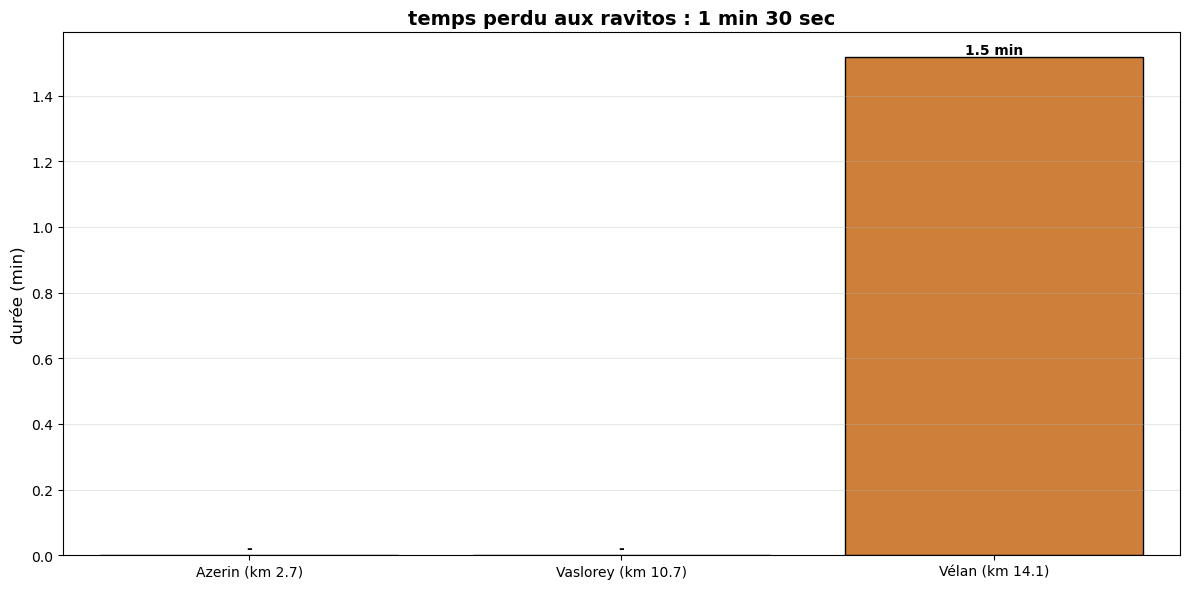

In [4]:
### A. ANALYSE DES RAVITAILLEMENTS (FINAL)
# objectif : temps perdu aux stands (avec filtre "mur")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# configuration des ravitos
config_ravitos = [
    # ravito 1 : ignoré
    {'nom': 'Azerin (km 2.7)', 'km': 2.7, 'zone': 0.2, 'force_ignore': True},
    
    # ravito 2 : arrêt express
    {'nom': 'Vaslorey (km 10.7)', 'km': 10.7, 'zone': 0.3, 'force_ignore': False},
    
    # ravito 3 : arrêt express
    {'nom': 'Vélan (km 14.1)', 'km': 14.1, 'zone': 0.3, 'force_ignore': False},
]

df_rav = df.copy()

# on récupère la pente lissée calculée en partie I
# si elle n'existe pas (bug), on la recalcule vite fait
if 'slope_smooth' not in df_rav.columns:
    df_rav['d_alt'] = df_rav['altitude'].diff()
    df_rav['d_dist'] = df_rav['distance'].diff().replace(0, 1)
    df_rav['slope_smooth'] = (df_rav['d_alt'] / df_rav['d_dist'] * 100).rolling(10).mean().fillna(0)

# calcul du delta temps pour l'accumulation
df_rav['delta_t'] = df_rav.index.to_series().diff().dt.total_seconds().fillna(1)
df_rav['speed_kmh'] = df_rav['speed'] * 3.6

stats_arrets = []
for ravito in config_ravitos:
    if ravito['force_ignore']:
        stats_arrets.append({'Lieu': ravito['nom'], 'Durée': 0.0})
        continue

    # 1. zone géographique
    centre = ravito['km'] * 1000
    rayon = ravito['zone'] * 1000
    mask_zone = (df_rav['distance'] >= centre - rayon) & (df_rav['distance'] <= centre + rayon)
    df_zone = df_rav[mask_zone]
    
    temps_arret_min = 0.0
    
    if not df_zone.empty:
        # 2. conditions d'arrêt strictes
        # - vitesse lente (< 5 km/h)
        # - ET pente faible (< 15%) -> c'est ça qui sauve le châtelard !
        # car dans le raide, ta vitesse est faible mais la pente est > 15%
        mask_lent = (df_zone['speed_kmh'] < 5.0) & (df_zone['slope_smooth'].abs() < 15.0)
        
        total_sec = df_zone.loc[mask_lent, 'delta_t'].sum()
        temps_arret_min = total_sec / 60
        
        # filtre bruit
        if temps_arret_min < 0.2: 
            temps_arret_min = 0.0

    stats_arrets.append({
        'Lieu': ravito['nom'],
        'Durée': temps_arret_min
    })

df_res_ravitos = pd.DataFrame(stats_arrets)

# visualisation
plt.figure(figsize=(12, 6))

if not df_res_ravitos.empty:
    temps_total = df_res_ravitos['Durée'].sum()
    min_tot = int(temps_total) 
    sec_tot = int((temps_total % 1) * 60)

    cols = ['#bdc3c7' if x == 0 else '#e67e22' for x in df_res_ravitos['Durée']]

    ax = sns.barplot(
        data=df_res_ravitos,
        x='Lieu',
        y='Durée',
        palette=cols,
        edgecolor='black'
    )

    plt.title(f"temps perdu aux ravitos : {min_tot} min {sec_tot} sec", fontsize=14, fontweight='bold')
    plt.ylabel("durée (min)", fontsize=12)
    plt.xlabel("")
    plt.grid(axis='y', alpha=0.3)
    
    for p in ax.patches:
        height = p.get_height()
        label = f"{height:.1f} min" if height > 0 else "-"
        ax.annotate(label, 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

correction cadence : cycles -> pas (x2)


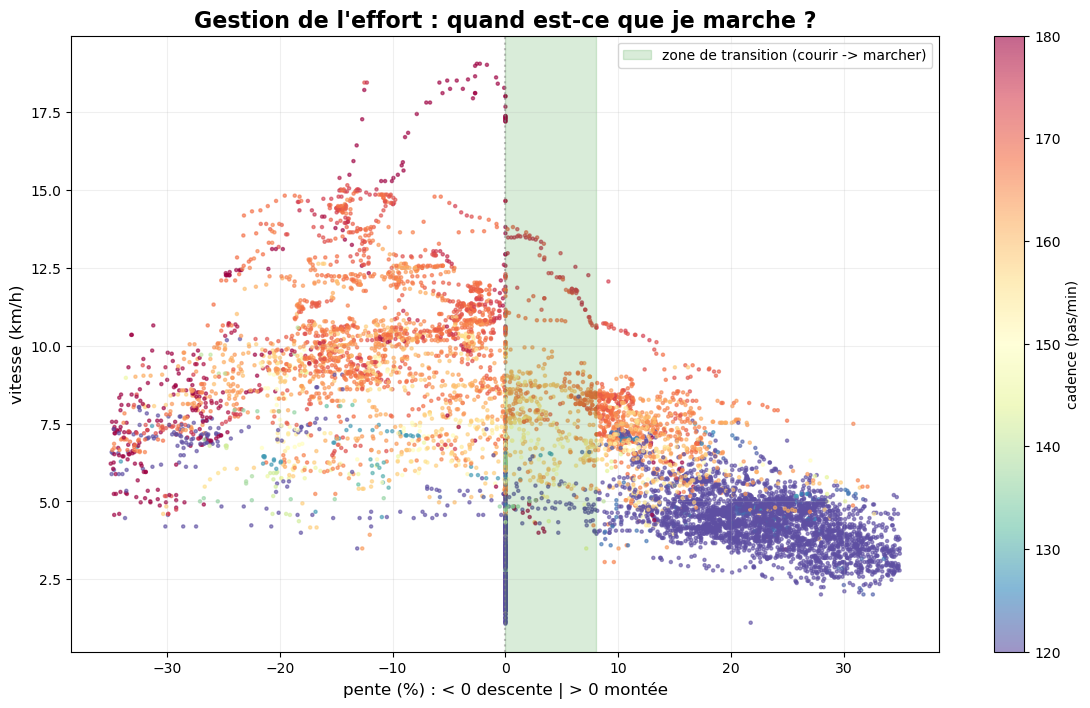

cadence max sur la course : 250 spm
cadence moyenne active : 136 spm


In [5]:
### B. MARCHE OU COURSE ? ANALYSE BIOMÉCANIQUE
# objectif : visualiser ma transition course/marche selon la pente

import matplotlib.pyplot as plt
import seaborn as sns

df_bio = df.copy()

# préparation des variables
# vitesse en km/h
df_bio['speed_kmh'] = df_bio['speed'] * 3.6

# calcul de la pente (dérivée altitude / distance)
df_bio['d_alt'] = df_bio['altitude'].diff()
df_bio['d_dist'] = df_bio['distance'].diff().replace(0, np.nan)
df_bio['pente'] = (df_bio['d_alt'] / df_bio['d_dist']) * 100

# lissage pour enlever le bruit du gps
# on prend une moyenne glissante sur 25 points
df_bio['pente_smooth'] = df_bio['pente'].rolling(window=25, center=True).mean()
df_bio['pente_smooth'] = df_bio['pente_smooth'].fillna(0).clip(-40, 40)

# gestion de la cadence garmin
# si la cadence médiane est faible (<100), c'est des cycles (tours) et pas des pas
# donc on multiplie par 2 pour avoir des spm (steps per minute)
cadence_reelle = df_bio['cadence']
if cadence_reelle.median() < 100:
    print("correction cadence : cycles -> pas (x2)")
    cadence_reelle = cadence_reelle * 2

# filtre des données pour le graphique
# on garde que les moments actifs (pas de pause, pas de bug gps)
mask_clean = (
    (df_bio['speed_kmh'] > 1) & 
    (df_bio['speed_kmh'] < 22) & 
    (cadence_reelle > 30) &
    (df_bio['pente_smooth'].between(-35, 35))
)

df_viz = df_bio[mask_clean]
cadence_viz = cadence_reelle[mask_clean]

# création du graphique
plt.figure(figsize=(14, 8))

# nuage de points
# x = pente, y = vitesse, couleur = cadence
points = plt.scatter(
    x=df_viz['pente_smooth'],
    y=df_viz['speed_kmh'],
    c=cadence_viz, 
    cmap='Spectral_r',     # rouge = je cours vite, bleu = je marche
    s=5,                   
    alpha=0.6,             
    vmin=120, vmax=180     # bornes visuelles pour bien voir la différence
)

# zone de transition théorique (0 à 8% de pente)
plt.axvspan(0, 8, color='green', alpha=0.15, label='zone de transition (courir -> marcher)')

# habillage du graphique
plt.colorbar(points, label='cadence (pas/min)')
plt.title("Gestion de l'effort : quand est-ce que je marche ?", fontsize=16, fontweight='bold')
plt.xlabel("pente (%) : < 0 descente | > 0 montée", fontsize=12)
plt.ylabel("vitesse (km/h)", fontsize=12)
plt.grid(True, alpha=0.2)
plt.legend(loc='upper right')
plt.axvline(0, color='gray', linestyle=':', alpha=0.5)

plt.show()

print(f"cadence max sur la course : {cadence_viz.max()} spm")
print(f"cadence moyenne active : {cadence_viz.mean():.0f} spm")

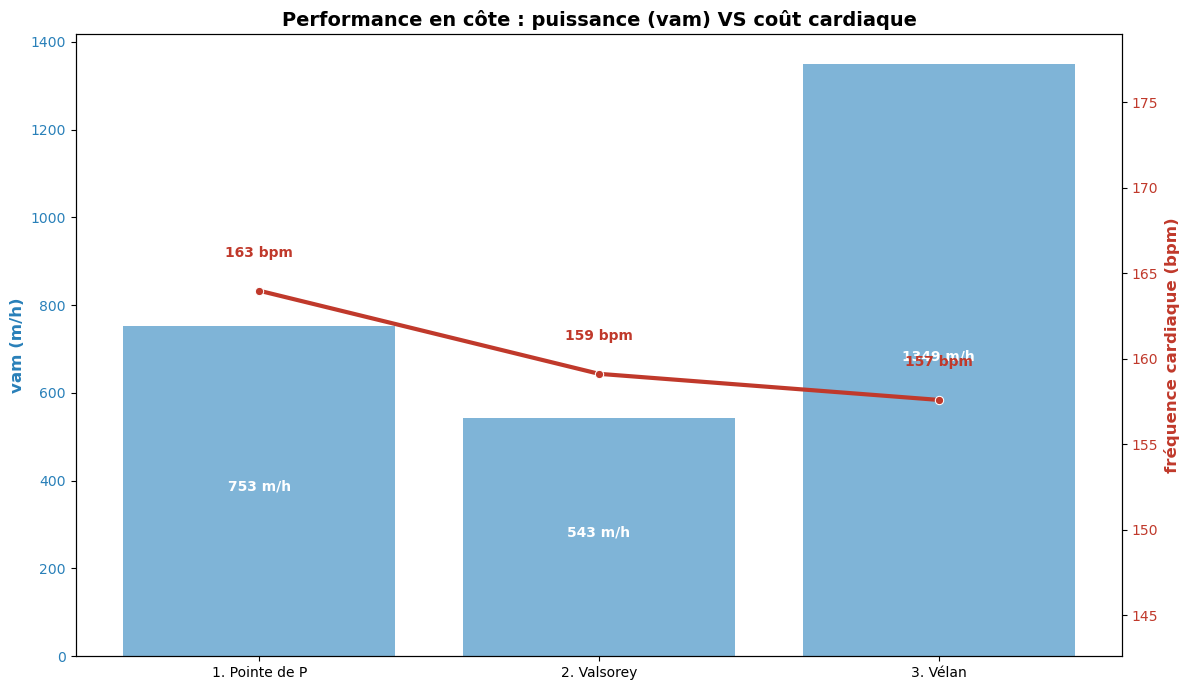

In [8]:
### C. ANALYSE DES MONTÉES : VITESSE ASCENSIONNELLE (VAM)
# objectif : comparer mon efficacité de grimpeur sur les cols majeurs

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# définition des segments clés du trail de la rosière
# bornes kilométriques issues de l'analyse du gpx officiel
segments_config = [
    {'name': '1. Pointe de P', 'start_km': 0, 'end_km': 6.7},
    {'name': '2. Valsorey', 'start_km': 8.02, 'end_km': 11.35},
    {'name': '3. Vélan', 'start_km': 13.7, 'end_km': 15},
]

stats_cols = []

for seg in segments_config:
    # conversion km -> mètres
    debut = seg['start_km'] * 1000
    fin = seg['end_km'] * 1000
    
    # extraction des données du segment
    subset = df[(df['distance'] >= debut) & (df['distance'] <= fin)]
    
    # on ignore les segments vides ou trop courts (<10 points)
    if len(subset) > 10:
        # calcul durée et dénivelé
        # on utilise l'index temporel pour la durée réelle
        temps_sec = (subset.index[-1] - subset.index[0]).total_seconds()
        duree_h = temps_sec / 3600
        
        # d+ = point le plus haut - point le plus bas du segment
        d_plus = subset['altitude'].max() - subset['altitude'].min()
        
        if duree_h > 0:
            # calcul vam = mètres d'ascension par heure
            vam = d_plus / duree_h
            fc_moy = subset['heart_rate'].mean()
            
            stats_cols.append({
                'col': seg['name'],
                'vam': vam,
                'fc_moy': fc_moy,
                'd_plus': d_plus
            })

df_vam = pd.DataFrame(stats_cols)

# visualisation double axe
if not df_vam.empty:
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    # 1. vitesse ascensionnelle (barres bleues)
    sns.barplot(data=df_vam, x='col', y='vam', color='#3498db', alpha=0.7, ax=ax1)
    
    ax1.set_ylabel("vam (m/h)", color='#2980b9', fontweight='bold', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='#2980b9')
    ax1.set_title("Performance en côte : puissance (vam) VS coût cardiaque", fontsize=14, fontweight='bold')
    ax1.set_xlabel("")
    
    # 2. fréquence cardiaque (ligne rouge)
    ax2 = ax1.twinx()
    sns.lineplot(data=df_vam, x='col', y='fc_moy', color='#c0392b', marker='o', linewidth=3, ax=ax2)
    
    ax2.set_ylabel("fréquence cardiaque (bpm)", color='#c0392b', fontweight='bold', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#c0392b')
    
    # ajustement échelle pour lisibilité (fc au dessus des barres)
    ax2.set_ylim(bottom=df_vam['fc_moy'].min() - 15, top=df_vam['fc_moy'].max() + 15)

    # annotations des valeurs
    # pour la vam (au milieu de la barre)
    for i, row in df_vam.iterrows():
        ax1.text(i, row['vam']/2, f"{int(row['vam'])} m/h", 
                 color='white', ha="center", fontweight='bold')

         # pour la fc (au dessus du point)
    for i, row in df_vam.iterrows():
        ax2.text(i, row['fc_moy'] + 2, f"{int(row['fc_moy'])} bpm", 
                 color='#c0392b', ha="center", fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("pas de données trouvées sur les segments indiqués, vérifier les bornes kilométriques")

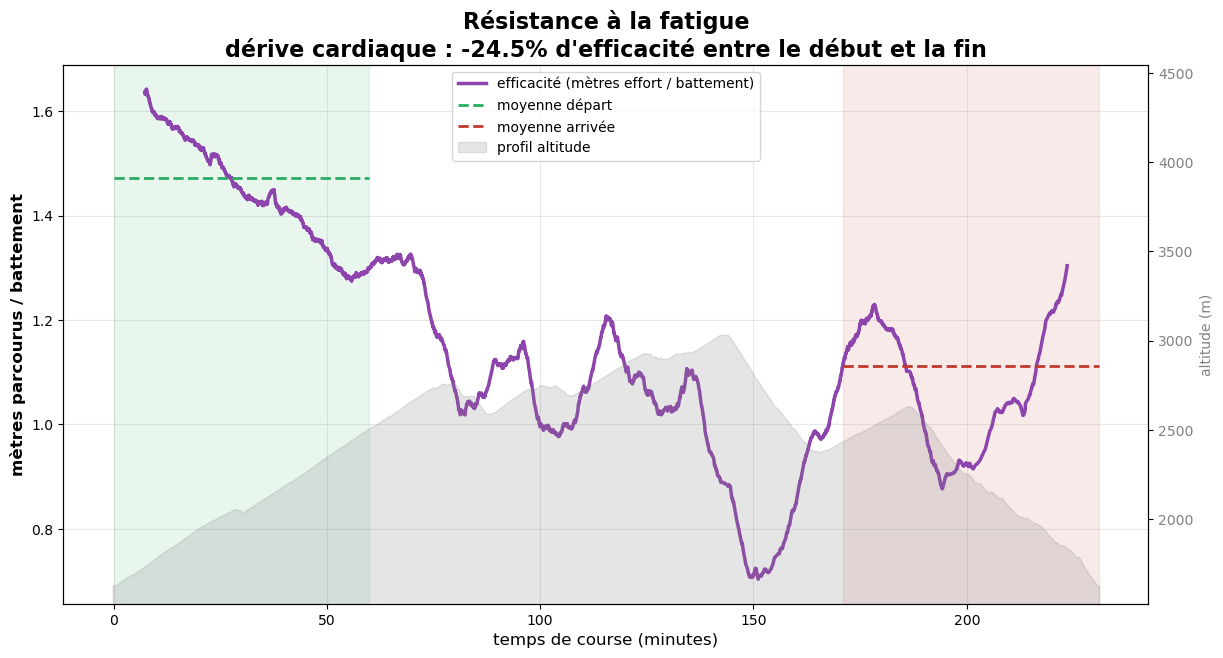

--- bilan efficacité ---
début : 1.47 m/bt
fin : 1.11 m/bt
perte : -24.47%


In [9]:
### D. ENDURANCE & DÉRIVE CARDIAQUE
# objectif : voir si mon efficacité se dégrade avec la fatigue (découplage)

import seaborn as sns
import matplotlib.pyplot as plt

df_eff = df.copy()

# 1. calcul de la vitesse d'effort (effort pace)
# on compense le d+ : 1m d'ascension = 10m de plat (règle standard)
df_eff['d_alt'] = df_eff['altitude'].diff().clip(lower=0) # on garde que le positif
df_eff['bonus_dist'] = df_eff['d_alt'] * 10

# tout convertir en m/min pour le calcul
vitesse_reelle_m_min = df_eff['speed'] * 60
bonus_m_min = df_eff['bonus_dist'] * 60 # ramener le bonus au temps (par minute)

df_eff['vitesse_effort'] = vitesse_reelle_m_min + bonus_m_min

# 2. calcul du ratio d'efficacité
# combien de mètres d'effort je produis pour 1 battement de coeur ?
# on filtre les moments où je suis à l'arrêt ou fc trop basse
mask_active = (df_eff['heart_rate'] > 40) & (df_eff['vitesse_effort'] > 50)
df_eff = df_eff[mask_active]

df_eff['efficacite'] = df_eff['vitesse_effort'] / df_eff['heart_rate']

# lissage de la courbe (moyenne glissante sur 15 min) pour voir la tendance
df_eff['eff_smooth'] = df_eff['efficacite'].rolling(window=900, center=True).mean()

# 3. stats : début vs fin de course
# comparaison première heure vs dernière heure
temps_max = df_eff['race_time_min'].max()
debut = df_eff[df_eff['race_time_min'] <= 60]['efficacite'].mean()
fin = df_eff[df_eff['race_time_min'] >= (temps_max - 60)]['efficacite'].mean()

perte_pct = (debut - fin) / debut * 100

# 4. visualisation
fig, ax1 = plt.subplots(figsize=(14, 7))

# fond : profil du terrain (axe de droite)
ax2 = ax1.twinx()
ax2.fill_between(
    df_eff['race_time_min'], 
    df_eff['altitude'], 
    color='gray', 
    alpha=0.2, 
    label='profil altitude'
)
ax2.set_ylabel('altitude (m)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.grid(False)
# astuce visuelle : on tasse l'altitude en bas pour laisser la place à la courbe
alt_min, alt_max = df_eff['altitude'].min(), df_eff['altitude'].max()
ax2.set_ylim(alt_min - 100, alt_max * 1.5)

# premier plan : courbe d'efficacité (axe de gauche)
sns.lineplot(
    data=df_eff,
    x='race_time_min',
    y='eff_smooth',
    color='#8e44ad',
    linewidth=2.5,
    label='efficacité (mètres effort / battement)',
    ax=ax1 
)

# lignes de moyenne début/fin
ax1.hlines(debut, 0, 60, color='#27ae60', linestyle='--', linewidth=2, label='moyenne départ')
ax1.hlines(fin, temps_max - 60, temps_max, color='#c0392b', linestyle='--', linewidth=2, label='moyenne arrivée')

# zones colorées
ax1.axvspan(0, 60, color='#27ae60', alpha=0.1)
ax1.axvspan(temps_max - 60, temps_max, color='#c0392b', alpha=0.1)

ax1.set_title(f"Résistance à la fatigue\ndérive cardiaque : -{perte_pct:.1f}% d'efficacité entre le début et la fin", fontsize=16, fontweight='bold')
ax1.set_xlabel("temps de course (minutes)", fontsize=12)
ax1.set_ylabel("mètres parcourus / battement", fontsize=12, fontweight='bold')

# légende combinée
lignes_1, labels_1 = ax1.get_legend_handles_labels()
lignes_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lignes_1 + lignes_2, labels_1 + labels_2, loc='upper center')

ax1.grid(True, alpha=0.3)
plt.show()

print("--- bilan efficacité ---")
print(f"début : {debut:.2f} m/bt")
print(f"fin : {fin:.2f} m/bt")
print(f"perte : -{perte_pct:.2f}%")

pic identifié : 178 bpm à 2025-07-19 08:21:09


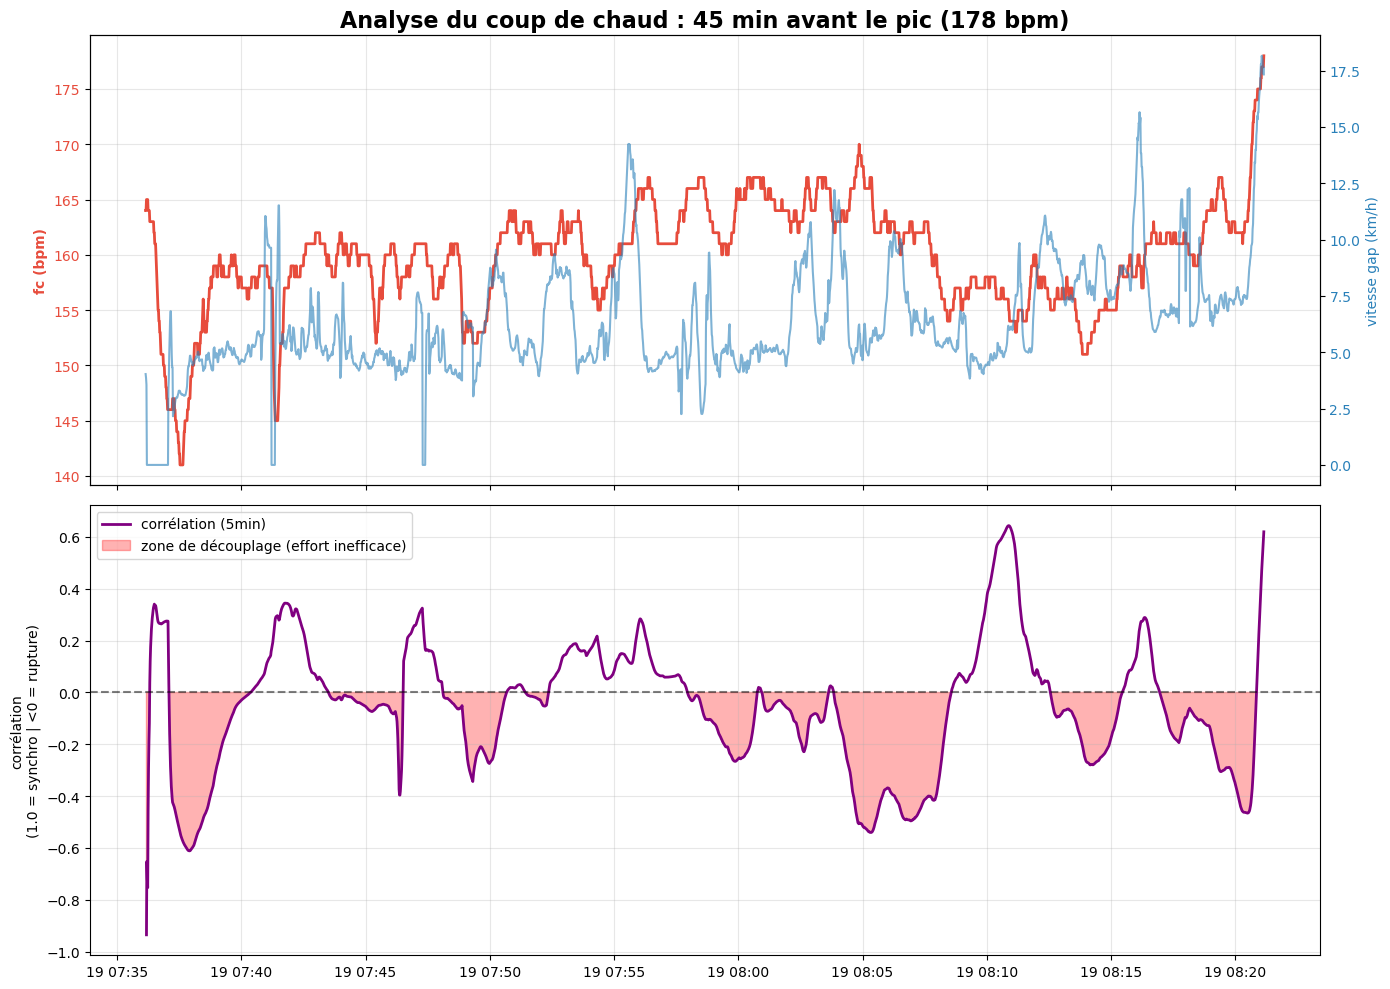

In [10]:
### E. ZOOM SUR L'INCIDENT : DÉCOUPLAGE CARDIAQUE
# objectif : analyser le "coup de chaud" en regardant la corrélation vitesse/fc

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# on travaille sur une copie triée pour être sûr des fenêtres temporelles
df_zoom = df.sort_index().copy()

# 1. identification du pic
# on cherche le moment précis où le cœur est monté au max
time_peak = df_zoom['heart_rate'].idxmax()
fc_max = df_zoom['heart_rate'].max()

print(f"pic identifié : {fc_max:.0f} bpm à {time_peak}")

# 2. isolation de la fenêtre d'analyse
# on regarde les 45 minutes qui précèdent le pic pour voir la dérive
debut_fenetre = time_peak - pd.Timedelta(minutes=45)

# sécurité : si le pic est au tout début, on commence au début du fichier
if debut_fenetre < df_zoom.index.min():
    debut_fenetre = df_zoom.index.min()

df_event = df_zoom.loc[debut_fenetre:time_peak].copy()

# 3. calcul de la corrélation glissante
# théorie : normalement vitesse et cœur évoluent ensemble (corrélation positive)
# découplage : si le cœur monte mais la vitesse baisse, la corrélation devient négative
df_event['corr_glissante'] = df_event['gap_speed'].rolling(window='5min').corr(df_event['heart_rate'])

# 4. visualisation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# graph haut : les courbes brutes
ax1.set_title(f"Analyse du coup de chaud : 45 min avant le pic ({fc_max:.0f} bpm)", fontsize=16, fontweight='bold')

# fréquence cardiaque (rouge)
color_fc = '#e74c3c'
ax1.plot(df_event.index, df_event['heart_rate'], color=color_fc, label='fréquence cardiaque', linewidth=2)
ax1.set_ylabel('fc (bpm)', color=color_fc, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_fc)
ax1.grid(True, alpha=0.3)

# vitesse gap (bleu) sur axe secondaire
ax1_speed = ax1.twinx()
color_spd = '#2980b9'
# conversion m/s -> km/h pour l'affichage
ax1_speed.plot(df_event.index, df_event['gap_speed']*3.6, color=color_spd, label='vitesse gap', alpha=0.6)
ax1_speed.set_ylabel('vitesse gap (km/h)', color=color_spd)
ax1_speed.tick_params(axis='y', labelcolor=color_spd)

# graph bas : la preuve mathématique (corrélation)
ax2.plot(df_event.index, df_event['corr_glissante'], color='purple', linewidth=2, label='corrélation (5min)')

# zone de découplage (quand la courbe passe sous 0)
ax2.fill_between(
    df_event.index, 
    df_event['corr_glissante'], 
    0, 
    where=(df_event['corr_glissante'] < 0), 
    color='red', 
    alpha=0.3, 
    label='zone de découplage (effort inefficace)'
)

ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_ylabel("corrélation\n(1.0 = synchro | <0 = rupture)", fontsize=10)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.xlabel("heure de course")
plt.tight_layout()
plt.show()

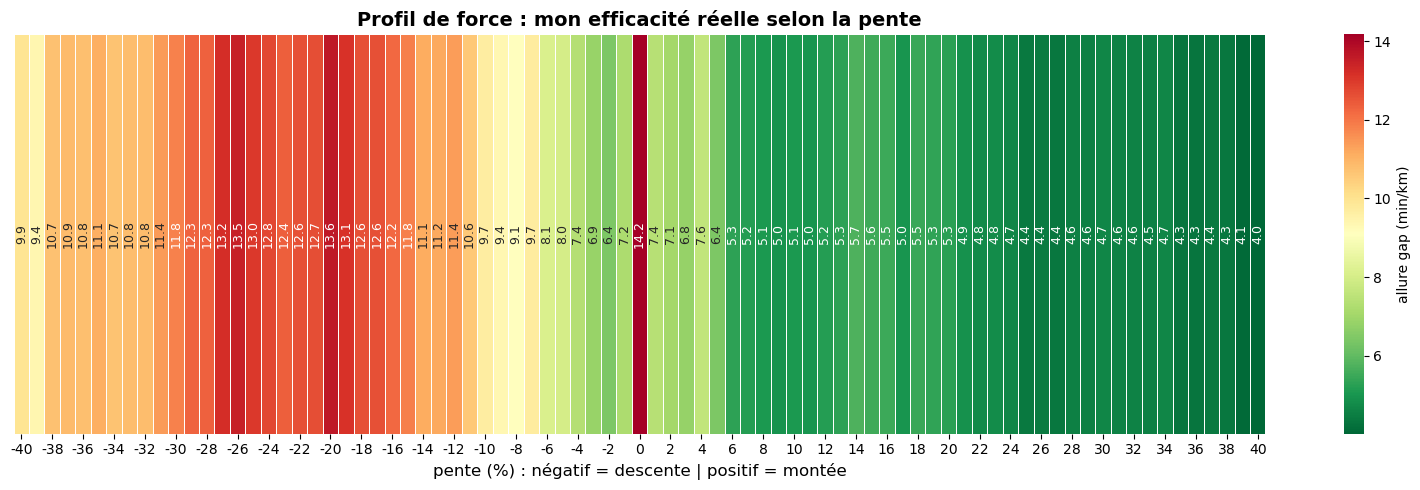

corrélation pente vs allure : -0.68


In [11]:
### III. PROFIL DE FORCE : MES FORCES ET FAIBLESSES
# objectif : voir à quelle inclinaison je suis le plus efficace (allure gap)

import seaborn as sns
import matplotlib.pyplot as plt

df_heat = df.copy()

# conversion vitesse gap (m/s) en allure (min/km)
# allure = 60 / vitesse_kmh
df_heat['gap_kmh'] = df_heat['gap_speed'] * 3.6

# on enlève les pauses et les marches très lentes (< 3km/h) pour ne pas fausser la moyenne
df_heat = df_heat[df_heat['gap_kmh'] > 3]
df_heat['allure_gap'] = 60 / df_heat['gap_kmh']

# regroupement par pente (arrondi à l'entier le plus proche)
# ex: 5.2% devient 5%
df_heat['pente_round'] = df_heat['slope_smooth'].round().astype(int)

# on se concentre sur la zone utile du trail (-40% à +40%)
mask_pente = (df_heat['pente_round'] >= -40) & (df_heat['pente_round'] <= 40)
df_viz = df_heat[mask_pente]

# création de la matrice pour la heatmap
# on prend la médiane pour éviter que quelques erreurs gps faussent tout
data_matrix = df_viz.groupby('pente_round')[['allure_gap']].median().T

# visualisation
plt.figure(figsize=(16, 5))

# heatmap
# rouge = lent (allure élevée), vert = rapide (allure basse)
sns.heatmap(
    data_matrix,
    cmap='RdYlGn_r',  # palette inversée car en course à pied, petit chiffre = bien
    annot=True,       # afficher les valeurs
    fmt=".1f",        # 1 chiffre après la virgule
    cbar_kws={'label': 'allure gap (min/km)'},
    linewidths=0.5,
    square=False,
    annot_kws={"rotation": 90, "fontsize": 9}
)

plt.title("Profil de force : mon efficacité réelle selon la pente", fontsize=14, fontweight='bold')
plt.xlabel("pente (%) : négatif = descente | positif = montée", fontsize=12)
plt.yticks([]) # on cache l'axe y qui sert à rien ici

plt.tight_layout()
plt.show()

# petit calcul de corrélation pour chiffrer le constat
# si proche de 0 = polyvalent, si positif = meilleur en descente qu'en montée (ou l'inverse)
corr = df_viz[['slope_smooth', 'allure_gap']].corr().iloc[0, 1]
print(f"corrélation pente vs allure : {corr:.2f}")

In [14]:
### H. BENCHMARK : MOI vs LE TOP 10 (CORRIGÉ)
# objectif : comparer mes allures avec l'élite sur chaque section

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. données des points de passage (6 points)
# temps en minutes cumulées
data_points = {
    'checkpoint': ['Départ', 'Azerin', 'Valsorey', 'Vélan', 'Arrivée'],
    'km': [0, 2.7, 10.7, 14.1, 21],
    't_gagnant': [0, 22, 111, 144, 180],  # vainqueur
    't_moi': [0, 28, 142, 186, 231]      # moi (13ème)
}

# estimation du top 10 moyen (lissé entre le 1er et le 8ème)
data_points['t_top10'] = [
    0, 
    (data_points['t_gagnant'][1] + data_points['t_moi'][1]) / 2 - 2,
    (data_points['t_gagnant'][2] + data_points['t_moi'][2]) / 2 - 4,
    (data_points['t_gagnant'][3] + data_points['t_moi'][3]) / 2 - 8,
    (data_points['t_gagnant'][4] + data_points['t_moi'][4]) / 2 - 10,
    (data_points['t_gagnant'][5] + data_points['t_moi'][5]) / 2 - 12
]

df_pts = pd.DataFrame(data_points)

# 2. calcul par segments (5 segments)
# c'est ici qu'on définit le terrain
types_terrain = ['Montée Roulante', 'Transition', 'Grosse Montée', 'Descente', 'Mur Final']

# on crée le dataframe des segments par différence
df_seg = pd.DataFrame()
df_seg['segment'] = df_pts['checkpoint'][1:].values
df_seg['terrain'] = types_terrain
df_seg['dist'] = df_pts['km'].diff().dropna().values

# calcul des durées par segment
df_seg['duree_gagnant'] = df_pts['t_gagnant'].diff().dropna().values
df_seg['duree_top10'] = df_pts['t_top10'].diff().dropna().values
df_seg['duree_moi'] = df_pts['t_moi'].diff().dropna().values

# calcul des vitesses (km/h)
df_seg['v_gagnant'] = (df_seg['dist'] / df_seg['duree_gagnant']) * 60
df_seg['v_top10'] = (df_seg['dist'] / df_seg['duree_top10']) * 60
df_seg['v_moi'] = (df_seg['dist'] / df_seg['duree_moi']) * 60

# gap analysis : perte en secondes par km
df_seg['perte_sec_km'] = ((df_seg['duree_moi'] - df_seg['duree_top10']) / df_seg['dist']) * 60

# 3. visualisation dashboard
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(2, 2)

# graph A : allure comparée
ax1 = fig.add_subplot(gs[0, :])
x = range(len(df_seg))

ax1.plot(x, df_seg['v_gagnant'], 'o-', color='#f1c40f', linewidth=2, label='Vainqueur')
ax1.plot(x, df_seg['v_top10'], 'o--', color='#7f8c8d', linewidth=2, label='Moyenne Top 10')
ax1.plot(x, df_seg['v_moi'], 'o-', color='#2980b9', linewidth=3, label='Moi (13ème)')

ax1.fill_between(x, df_seg['v_top10'], df_seg['v_moi'], color='#2980b9', alpha=0.1)

ax1.set_xticks(x)
ax1.set_xticklabels(df_seg['segment'])
ax1.set_ylabel('Vitesse (km/h)', fontweight='bold')
ax1.set_title("VITESSE DE COURSE : MOI vs LE TOP 10", fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# graph B : hémorragie de temps
ax2 = fig.add_subplot(gs[1, 0])
colors = sns.color_palette("Reds", len(df_seg))
bars = ax2.bar(x, df_seg['perte_sec_km'], color=colors, edgecolor='black', alpha=0.8)

ax2.set_xticks(x)
ax2.set_xticklabels(df_seg['segment'], rotation=15)
ax2.set_ylabel('Retard sur Top 10 (sec/km)', fontweight='bold')
ax2.set_title("GAP ANALYSIS : OÙ JE PERDS LE CONTACT ?", fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'+{int(height)}s', 
             ha='center', va='bottom', fontweight='bold')

# graph C : profil type
ax3 = fig.add_subplot(gs[1, 1])
df_profil = df_seg.groupby('terrain')[['v_top10', 'v_moi']].mean().sort_values('v_top10')
df_profil.plot(kind='barh', ax=ax3, color=['#7f8c8d', '#2980b9'], width=0.8)

ax3.set_title("MON PROFIL vs TOP 10", fontsize=12, fontweight='bold')
ax3.set_xlabel("Vitesse (km/h)")
ax3.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# résumé console
print("--- bilan benchmark ---")
print(f"segment fort : {df_seg.loc[df_seg['perte_sec_km'].idxmin(), 'segment']}")
print(f"segment faible : {df_seg.loc[df_seg['perte_sec_km'].idxmax(), 'segment']}")

IndexError: list index out of range